In [41]:
import json

inst_vocab_path = '/workspace/data/vocabs/inst.json'
chord_vocab_path = '/workspace/data/vocabs/chord.json'
with open(inst_vocab_path, 'r') as file:
    inst_vocab = json.load(file)
    
    
import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.nn.functional as F
import math
from transformers import ASTConfig, ASTModel, GPT2Config, GPT2Model, AutoModelForCausalLM, GPT2LMHeadModel, BartConfig

# class GPT2Model(nn.Module):
#     def __init__(self, vocab_size=140, n_embd=768, n_layer=12, n_head=12):
#         super(GPT2Model, self).__init__()
#         self.configuration = GPT2Config(vocab_size=vocab_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head, bos_token_id=2, eos_token_id=1)
#         self.model = GPT2LMHeadModel(self.configuration)
        
#     def get_embed(self, idx):
#         embedding_layer = self.model.transformer.wte
#         token_embedding = embedding_layer(torch.tensor([idx]))
#         return token_embedding
    
#     def extract_vocab_embeddings(self):
#         # Extract all the embeddings for the entire vocabulary
#         embedding_layer = self.model.transformer.wte
#         vocab_embeddings = embedding_layer.weight.detach().clone()
#         return vocab_embeddings

#     def forward(self, input_ids, labels=None, return_hidden_states=False):
#         attention_mask = self.make_mask(input_ids)
#         # Forward pass through the transformer to get hidden states
#         transformer_outputs = self.model.transformer(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

#         # Extract hidden states before the projection
#         hidden_states = transformer_outputs.last_hidden_state
        
#         if return_hidden_states:
#             return hidden_states

#         # Project the hidden states to vocabulary size
#         logits = self.model.lm_head(hidden_states)

#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.configuration.vocab_size), labels.view(-1))
#             return loss, logits
#         return logits

#     def make_mask(self, input_ids):
#         attention_mask = (input_ids != 0).long()
#         return attention_mask
    
#     def infer(self, input_ids, length=2048):
#         if len(input_ids.shape) == 1:
#             input_ids = input_ids.unsqueeze(0)
#         if len(input_ids.shape) > 2:
#             raise Exception
        
#         if length > 2048:
#             print("Max Length is 2048. Change Length Auto to 2048")
#             length = 2048
        
#         with torch.no_grad():
#             for step in range(length):
#                 logits = self.forward(input_ids)
#                 output = torch.argmax(logits, dim=2)

#                 predict = output[:,-1].unsqueeze(1)
#                 output_ids = torch.cat((input_ids, predict), dim=-1)

#                 input_ids = output_ids
                
#                 if output_ids.shape[1] > 2048:
#                     break

#         return output_ids

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]  # Broadcasting positional encodings
        return x  # Shape: (batch_size, seq_len, d_model)
    
class NormEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(NormEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x, lengths):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]  # Broadcasting positional encodings
        return x  # Shape: (batch_size, seq_len, d_model)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0  # d_model must be divisible by num_heads
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])  # Q, K, V, and output projections

    def forward(self, query, key, value, mask=None):
        # query, key, value shape: (batch_size, seq_len, d_model)
        batch_size = query.size(0)

        # Linear projections
        query, key, value = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        # After projection and reshaping: (batch_size, num_heads, seq_len, d_k)

        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn, value)
        # attn_output shape: (batch_size, num_heads, seq_len, d_k)

        # Concatenate heads and apply final linear projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linears[-1](attn_output)  # Shape: (batch_size, seq_len, d_model)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return self.linear2(F.relu(self.linear1(x)))  # Shape: (batch_size, seq_len, d_model)
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, d_model)
        attn_output = self.self_attn(x, x, x, mask)  # Self-attention
        x = x + self.dropout(attn_output)  # Add & Norm
        x = self.layernorm1(x)

        ff_output = self.feed_forward(x)  # Feed forward
        x = x + self.dropout(ff_output)  # Add & Norm
        return self.layernorm2(x)  # Shape: (batch_size, seq_len, d_model)
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask=None, tgt_mask=None):
        # x shape: (batch_size, tgt_len, d_model)
        # memory shape: (batch_size, src_len, d_model)

        attn_output = self.self_attn(x, x, x, tgt_mask)  # Self-attention
        x = x + self.dropout(attn_output)  # Add & Norm
        x = self.layernorm1(x)

        attn_output = self.cross_attn(x, memory, memory, src_mask)  # Cross-attention
        x = x + self.dropout(attn_output)  # Add & Norm
        x = self.layernorm2(x)

        ff_output = self.feed_forward(x)  # Feed forward
        x = x + self.dropout(ff_output)  # Add & Norm
        return self.layernorm3(x)  # Shape: (batch_size, tgt_len, d_model)
    
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, max_len, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, src_len)
        x = self.embedding(src)  # Embedding
        # x shape: (batch_size, src_len, d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x  # Shape: (batch_size, src_len, d_model)
    
class C2IEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, max_len, dropout=0.1, mode='none'):
        super(C2IEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.num_classes = 133
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, 133)
        if mode == 'len':
            self.len_embed = nn.Embedding(770, d_model)

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, src_len)
        
        src_mask = self.generate_src_mask(src)  # Generate source mask
        
        x = self.embedding(src)  # Embedding
        # x shape: (batch_size, src_len, d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x  # Shape: (batch_size, src_len, d_model)
    
    def generate_src_mask(self, src):
        # src shape: (batch_size, src_len)
        return (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)
    
    def proj_inst(self, x, length=None):
        # x shape: (batch_size, src_len, d_model)
        
        # Use the embedding corresponding to the BOS token (assumed to be the first token)
        bos_embedding = x[:, 0, :]  # Shape: (batch_size, d_model)
        
        if length == None:
            # First fully connected layer
            x = self.fc1(bos_embedding)  # Shape: (batch_size, d_model // 2)
            x = torch.relu(x)  # Apply ReLU activation
            
            # Second fully connected layer
            out = self.fc2(x)  # Shape: (batch_size, num_classes)
        else:
            # First fully connected layer
            len_embed = self.len_embed(length)
            len_embed = len_embed.squeeze(1)
            len_embed = len_embed/4

            bos_embedding = bos_embedding + len_embed
            x = self.fc1(bos_embedding)  # Shape: (batch_size, d_model // 2)
            x = torch.relu(x)  # Apply ReLU activation
            
            # Second fully connected layer
            out = self.fc2(x)  # Shape: (batch_size, num_classes)
        
        return out
    
    def avg_inst(self, x, length=None):
        # x shape: (batch_size, src_len, d_model)
        
        # Use the embedding corresponding to the BOS token (assumed to be the first token)
        bos_embedding = torch.mean(x, dim=1)  # Shape: (batch_size, d_model)
        
        if length == None:
            # First fully connected layer
            x = self.fc1(bos_embedding)  # Shape: (batch_size, d_model // 2)
            x = torch.relu(x)  # Apply ReLU activation
            
            # Second fully connected layer
            out = self.fc2(x)  # Shape: (batch_size, num_classes)
        else:
            # First fully connected layer
            len_embed = self.len_embed(length)
            len_embed = len_embed.squeeze(1)
            len_embed = len_embed/4
            bos_embedding = bos_embedding + len_embed
            x = self.fc1(bos_embedding)  # Shape: (batch_size, d_model // 2)
            x = torch.relu(x)  # Apply ReLU activation
            
            # Second fully connected layer
            out = self.fc2(x)  # Shape: (batch_size, num_classes)
        
        return out

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, max_len, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, src_mask=None, tgt_mask=None):
        # tgt shape: (batch_size, tgt_len)
        x = self.embedding(tgt)  # Embedding
        # x shape: (batch_size, tgt_len, d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x  # Shape: (batch_size, tgt_len, d_model)
    
class InstDecoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, max_len, dropout=0.1):
        super(InstDecoder, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, src_mask=None, tgt_mask=None):
        
        x = self.positional_encoding(tgt)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x  # Shape: (batch_size, tgt_len, d_model)
    
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, d_ff=2048, num_layers=6, max_len=5000, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, src_vocab_size, max_len, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, tgt_vocab_size, max_len, dropout)
        self.out = nn.Linear(d_model, tgt_vocab_size)
        
    def generate_src_mask(self, src):
        # src shape: (batch_size, src_len)
        return (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)

    def generate_tgt_mask(self, tgt):
        # tgt shape: (batch_size, tgt_len)
        tgt_len = tgt.size(1)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)  # Padding mask: (batch_size, 1, 1, tgt_len)
        nopeak_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()  # Look-ahead mask
        tgt_mask = tgt_mask & nopeak_mask.unsqueeze(0)  # Combined mask: (batch_size, 1, tgt_len, tgt_len)
        return tgt_mask

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # src shape: (batch_size, src_len)
        # tgt shape: (batch_size, tgt_len)
        
        src_mask = self.generate_src_mask(src)  # Generate source mask
        tgt_mask = self.generate_tgt_mask(tgt)  # Generate target mask

        memory = self.encoder(src, src_mask)  # Encoder output
        # memory shape: (batch_size, src_len, d_model)

        output = self.decoder(tgt, memory, src_mask, tgt_mask)  # Decoder output
        # output shape: (batch_size, tgt_len, d_model)

        return self.out(output)  # Final output projection, shape: (batch_size, tgt_len, tgt_vocab_size)
    
    def infer(self, src, x, length=766):
        with torch.no_grad():
            for step in range(length):
                output = self.forward(src, x)
                output = torch.argmax(output, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((x, predict), dim=-1)

                x = output_ids
                
                # if torch.all(predict.eq(0)):
                #     break
                
                if output_ids.shape[1] > 2048:
                    break

        return output_ids
        
    
    
class InstEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, inst_size, max_len, dropout=0.1):
        super(InstEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.inst_proj = nn.Linear(d_model, inst_size)
        
    def generate_src_mask(self, src):
        # src shape: (batch_size, src_len)
        return (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, src_len)
        x = self.embedding(src)  # Embedding
        # x shape: (batch_size, src_len, d_model)
        
        src_mask = self.generate_src_mask(src)  # Generate source mask
        
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        x = self.inst_proj(x)
        return x  # Shape: (batch_size, src_len, inst_size)
    
class InstNoPEEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, inst_size, max_len, dropout=0.1):
        super(InstNoPEEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.inst_proj = nn.Linear(d_model, inst_size)
        
    def generate_src_mask(self, src):
        # src shape: (batch_size, src_len)
        return (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, src_len)
        x = self.embedding(src)  # Embedding
        # x shape: (batch_size, src_len, d_model)
        
        src_mask = self.generate_src_mask(src)  # Generate source mask
        
        # x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        x = self.inst_proj(x)
        return x  # Shape: (batch_size, src_len, inst_size)

class InstNormEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, vocab_size, inst_size, max_len, dropout=0.1):
        super(InstEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model//2)
        self.norm_pos = nn.Embedding(100, d_model//2)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.inst_proj = nn.Linear(d_model, inst_size)
        
    def generate_src_mask(self, src):
        # src shape: (batch_size, src_len)
        return (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, src_len)
        x = self.embedding(src)  # Embedding
        norm_pos = self.embedding()
        # x shape: (batch_size, src_len, d_model)
        
        src_mask = self.generate_src_mask(src)  # Generate source mask
        
        # x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        x = self.inst_proj(x)
        return x  # Shape: (batch_size, src_len, inst_size)

class InstTransformer(nn.Module):
    def __init__(self, device='cpu', d_model=768, num_heads=8, d_ff=2048, num_layers=6, max_len=5000, dropout=0.1):
        super(InstTransformer, self).__init__()
        self.device = device
        self.chord_encoder = GPT2Model(vocab_size=150)
        self.chord_encoder.load_state_dict(torch.load('/workspace/out/chord_bpe/GPT2_BPE_V150/model_207_0.4520_0.3645.pt'))
        # Freeze the chord_transformer parameters
        for param in self.chord_encoder.parameters():
            param.requires_grad = False
            
        self.inst_embedding = nn.Embedding(133, 768)
        self.init_inst_bos_proj = nn.Linear(133, 768)
        
        self.decoder = InstDecoder(d_model, num_heads, d_ff, num_layers, max_len, dropout)
        
        self.out = nn.Linear(d_model, 1)

    def forward(self, chord_tensor, init_inst_tensor, inst_idx):
        memory = self.chord_encoder(chord_tensor, return_hidden_states=True)
        
        length = memory.shape[1] - 2
        
        init_inst_embed = self.init_inst_bos_proj(init_inst_tensor)
        init_inst_embed = init_inst_embed.unsqueeze(1).repeat(1, 1, 1)
        
        # out_embed = self.inst_poolers[inst_idx](input_embed)
        inst_idx = torch.tensor([inst_idx]).to(self.device)
        # print(inst_idx.shape)
        inst_embed = self.inst_embedding(inst_idx)
        inst_embed = inst_embed.unsqueeze(1).repeat(1, length-1, 1)
        # print(inst_embed.shape)
        decoder_input_embed = torch.cat((init_inst_embed, inst_embed), dim=1)
        # print(decoder_input_embed.shape)
        decoder_output = self.decoder(decoder_input_embed, memory)
        
        out_embed = self.out(decoder_output)
        
        return out_embed
    
    def infer(self, chord_tensor, init_inst_tensor):
        # src shape: (batch_size, src_len)
        # tgt shape: (batch_size, tgt_len)
        
        # src_mask = self.generate_src_mask(src)  # Generate source mask
        # tgt_mask = self.generate_tgt_mask(tgt)  # Generate target mask

        memory = self.chord_encoder(chord_tensor, return_hidden_states=True)  # Encoder output
        # memory shape: (batch_size, src_len, d_model)
        
        length = memory.shape[1] - 2
        
        init_inst_embed = self.init_inst_bos_proj(init_inst_tensor)
        init_inst_embed = init_inst_embed.unsqueeze(1).repeat(1, 1, 1)
        
        output_container = []
        
        for inst_idx in range(133):
            # out_embed = self.inst_poolers[inst_idx](input_embed)
            inst_idx = torch.tensor([inst_idx]).to(self.device)
            # print(inst_idx.shape)
            inst_embed = self.inst_embedding(inst_idx)
            inst_embed = inst_embed.unsqueeze(1).repeat(1, length-1, 1)
            # print(inst_embed.shape)
            decoder_input_embed = torch.cat((init_inst_embed, inst_embed), dim=1)
            # print(decoder_input_embed.shape)
            decoder_output = self.decoder(decoder_input_embed, memory)
            
            out_embed = self.out(decoder_output)
            
            output_container.append(out_embed)
        
        return output_container
    
class GPT2Model(nn.Module):
    def __init__(self, vocab_size=140, n_embd=768, n_layer=12, n_head=12):
        super(GPT2Model, self).__init__()
        self.configuration = GPT2Config(vocab_size=vocab_size, n_embd=n_embd, n_layer=n_layer, n_head=n_head, bos_token_id=2, eos_token_id=1)
        self.model = GPT2LMHeadModel(self.configuration)
        
    def get_embed(self, idx):
        embedding_layer = self.model.transformer.wte
        token_embedding = embedding_layer(torch.tensor([idx]))
        return token_embedding
    
    def extract_vocab_embeddings(self):
        # Extract all the embeddings for the entire vocabulary
        embedding_layer = self.model.transformer.wte
        vocab_embeddings = embedding_layer.weight.detach().clone()
        return vocab_embeddings

    def forward(self, input_ids, labels=None, return_hidden_states=False):
        attention_mask = self.make_mask(input_ids)
        # Forward pass through the transformer to get hidden states
        transformer_outputs = self.model.transformer(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract hidden states before the projection
        hidden_states = transformer_outputs.last_hidden_state
        
        if return_hidden_states:
            return hidden_states

        # Project the hidden states to vocabulary size
        logits = self.model.lm_head(hidden_states)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.configuration.vocab_size), labels.view(-1))
            return loss, logits
        return logits

    def make_mask(self, input_ids):
        attention_mask = (input_ids != 0).long()
        return attention_mask
    
    def infer(self, input_ids, length=2048):
        if len(input_ids.shape) == 1:
            input_ids = input_ids.unsqueeze(0)
        if len(input_ids.shape) > 2:
            raise Exception
        
        if length > 2048:
            print("Max Length is 2048. Change Length Auto to 2048")
            length = 2048
        
        with torch.no_grad():
            for step in range(length):
                logits = self.forward(input_ids)
                output = torch.argmax(logits, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((input_ids, predict), dim=-1)

                input_ids = output_ids
                
                if output_ids.shape[1] > 2048:
                    break

        return output_ids

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        # self.norm1 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_features, out_features)
        # self.norm2 = nn.BatchNorm1d(out_features)

    def forward(self, x):
        residual = x
        out = self.linear1(x)
        # out = self.norm1(out)
        out = self.relu(out)
        out = self.linear2(out)
        # out = self.norm2(out)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out

class C2ITransformer(nn.Module):
    def __init__(self, mode='proj'):
        super(C2ITransformer, self).__init__()
        
        self.chord_encoder = GPT2Model(vocab_size=150)
        self.chord_encoder.load_state_dict(torch.load('/workspace/out/chord_bpe/GPT2_BPE_V150/model_207_0.4520_0.3645.pt'))
        # Freeze the chord_transformer parameters
        for param in self.chord_encoder.parameters():
            param.requires_grad = False
            
        self.mode = mode
        
        self.hidden_map = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            ResidualBlock(256, 256),
            nn.Linear(256, 128),
            nn.ReLU(),
            ResidualBlock(128,128),
            nn.Linear(128,133)
        )
            
    
    def forward(self, chord_tensor):
        # Encoder
        chord_embedding = self.chord_encoder(chord_tensor, return_hidden_states=True)
        
        if self.mode == 'avg':
            pass
        
        elif self.mode == 'bos':
            chord_tensor = chord_embedding[:,0,:]
            
            output = self.hidden_map(chord_tensor)
            output = torch.sigmoid(output)
            return output
        
    def jaccard_loss(self, pred, target):
        eps = 1e-10

        intersection = torch.sum(pred * target)
        union = torch.sum(pred) + torch.sum(target) - intersection
        sim = (intersection + eps) / (union + eps)
        return 1 - sim
    
    def hamming_loss(self, y_pred, y_true):
        
        # 이진화 없이 차이 계산 (torch.abs 사용)
        hamming_distance = torch.sum(torch.abs(y_true - y_pred))
        
        # 벡터 길이로 나누어 해밍 손실 계산
        hamming_loss = hamming_distance / y_true.numel()
        return hamming_loss
    
    def bce_loss(self, logits, targets):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, targets)
        return loss
    


In [2]:
import torch
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

class InstDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        inst_vocab_path = '/workspace/data/vocabs/inst.json'
        chord_vocab_path = '/workspace/data/vocabs/chord.json'
        with open(inst_vocab_path, 'r') as file:
            self.inst_vocab = json.load(file)
        with open(chord_vocab_path, 'r') as file:
            self.chord_vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
            
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        inst_in_measure = []
        inst_list = []
        
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'H':
                chord_list.append(t1)

            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_in_measure.append(t4)
                
            if (t1[0] == 'm' or t1[0] == 'M') and len(chord_list) > 0:
                inst_list.append(inst_in_measure)
                inst_in_measure = []
        inst_list.append(inst_in_measure)
        
        chord_tensor = [self.chord_vocab[chd] for chd in chord_list]
        inst_tensor, length = self.convert_inst_to_onehot(inst_list)
        
        target_chord_tensor = [2] + chord_tensor[:766] + [1]
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        target_inst_tensor = inst_tensor

        return target_chord_tensor, target_inst_tensor, length+2
    
    def convert_inst_to_onehot(self, inst_list):
        base_tensor = torch.zeros(len(inst_list), 133)
        bos_tensor = torch.zeros(1, 133)
        eos_tensor = torch.zeros(1, 133)
        bos_tensor[:,2] = 1
        eos_tensor[:,1] = 1
        
        for idx, inst_in_measure in enumerate(inst_list):
            if len(inst_in_measure) == 0:
                continue
            else:
                for inst in inst_in_measure:
                    base_tensor[idx, self.inst_vocab[inst]] = 1
        inst_tensor = torch.cat((bos_tensor,base_tensor[:766,:],eos_tensor), dim=0)
        return inst_tensor, len(inst_list)
  
class InstGroupDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        inst_vocab_path = '/workspace/data/vocabs/inst_group60_vocab.json'
        chord_vocab_path = '/workspace/data/vocabs/chord.json'
        with open(inst_vocab_path, 'r') as file:
            self.inst_vocab = json.load(file)
        with open(chord_vocab_path, 'r') as file:
            self.chord_vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
            
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        inst_in_measure = []
        inst_list = []
        
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'H':
                chord_list.append(t1)

            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_in_measure.append(t4)
                
            if (t1[0] == 'm' or t1[0] == 'M') and len(chord_list) > 0:
                inst_list.append(inst_in_measure)
                inst_in_measure = []
        inst_list.append(inst_in_measure)
        
        chord_tensor = [self.chord_vocab[chd] for chd in chord_list]
        inst_tensor, length = self.convert_inst_to_onehot(inst_list)
        
        target_chord_tensor = [2] + chord_tensor[:510] + [1]
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        target_inst_tensor = [2] + inst_tensor[:510] + [1]
        length = len(target_inst_tensor)
        target_inst_tensor = torch.tensor(target_inst_tensor)

        return target_chord_tensor, target_inst_tensor, torch.tensor([length])
    
    def convert_inst_to_onehot(self, inst_list):
        inst_vocab = []
        
        for insts in inst_list:
            group_inst = ''
            for inst in insts:
                if inst in group_inst:
                    pass
                else:
                    group_inst += inst
            
            try:
                inst_vocab.append(self.inst_vocab[group_inst])
            except:
                inst_vocab.append(3)
                
        return inst_vocab, len(inst_list)
    
class C2IDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        inst_vocab_path = '/workspace/data/vocabs/inst.json'
        chord_vocab_path = '/workspace/data/vocabs/chord.json'
        with open(inst_vocab_path, 'r') as file:
            self.inst_vocab = json.load(file)
        with open(chord_vocab_path, 'r') as file:
            self.chord_vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
            
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        inst_in_measure = []
        inst_list = []
        
        inst_tensor = torch.zeros(133)
        
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'H':
                chord_list.append(t1)

            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_tensor[self.inst_vocab[t4]] = 1
        
        chord_tensor = [self.chord_vocab[chd] for chd in chord_list]
        
        target_chord_tensor = [2] + chord_tensor[:766] + [1]
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        target_inst_tensor = inst_tensor

        return target_chord_tensor, target_inst_tensor, torch.tensor([target_chord_tensor.shape[0]])
    
class InstGRUDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        inst_vocab_path = '/workspace/data/vocabs/inst.json'
        chord_vocab_path = '/workspace/data/vocabs/chord.json'
        with open(inst_vocab_path, 'r') as file:
            self.inst_vocab = json.load(file)
        with open(chord_vocab_path, 'r') as file:
            self.chord_vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
            
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        ans_inst_container = []
        inst_in_measure = []
        inst_list = []
        inst_tensor = torch.zeros(133)
        
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'h' or t1[0] == 'H':
                chord_list.append(t1)

            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_tensor[self.inst_vocab[t4]] = 1
                
            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_in_measure.append(t4)
                
            if (t1[0] == 'm' or t1[0] == 'M') and len(chord_list) > 0:
                inst_list.append(inst_in_measure)
                inst_in_measure = []
        
        inst_list.append(inst_in_measure)

        chord_tensor = [self.chord_vocab[chd] for chd in chord_list]
        ans_inst_container = self.convert_inst_to_onehot(inst_list, ans_inst_container)
        
        target_chord_tensor = [2] + chord_tensor[:766] + [1]
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        init_inst_tensor = inst_tensor

        return target_chord_tensor, init_inst_tensor, ans_inst_container
    
    def convert_inst_to_onehot(self, inst_list, ans_inst_container):
        
        for _ in range(133):
            ans_inst_container.append([0]*len(inst_list))
        
        for idx, inst_in_measure in enumerate(inst_list):
            if len(inst_in_measure) == 0:
                continue
            else:
                for inst in inst_in_measure:
                    # base_tensor[idx, self.inst_vocab[inst]] = 1
                    ans_inst_container[self.inst_vocab[inst]][idx] = 1
                    
        for idx, vec in enumerate(ans_inst_container):
            ans_inst_container[idx] = torch.tensor(vec[:766])
        
        return ans_inst_container
   
class InstVAEDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        inst_vocab_path = '/workspace/data/vocabs/inst.json'
        chord_vocab_path = '/workspace/data/vocabs/chord.json'
        with open(inst_vocab_path, 'r') as file:
            self.inst_vocab = json.load(file)
        with open(chord_vocab_path, 'r') as file:
            self.chord_vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
            
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        init_instruments = [0]*133
        inst_in_measure = []
        inst_list = []
        
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'H':
                chord_list.append(t1)

            if t4[0] == 'x' or t4[0] == 'X' or t4[0] == 'y' or t4 == '<unk>':
                inst_in_measure.append(t4)
                
                init_instruments[self.inst_vocab[t4]] = 1
                
            if (t1[0] == 'm' or t1[0] == 'M') and len(chord_list) > 0:
                inst_list.append(inst_in_measure)
                inst_in_measure = []
        inst_list.append(inst_in_measure)
        
        chord_tensor = [self.chord_vocab[chd] for chd in chord_list]
        inst_tensor, length = self.convert_inst_to_onehot(inst_list)
        
        target_chord_tensor = [2] + chord_tensor[:766] + [1]
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        target_init_inst_tensor = torch.tensor(init_instruments)
        
        target_inst_tensor = inst_tensor

        return target_chord_tensor, target_init_inst_tensor, target_inst_tensor, length
    
    def convert_inst_to_onehot(self, inst_list):
        base_tensor = torch.zeros(len(inst_list), 133)
        
        for idx, inst_in_measure in enumerate(inst_list):
            if len(inst_in_measure) == 0:
                continue
            else:
                for inst in inst_in_measure:
                    base_tensor[idx, self.inst_vocab[inst]] = 1
        inst_tensor = base_tensor[:766,:]
        return inst_tensor, len(inst_tensor)
    
def create_dataloaders(batch_size):
    raw_data_path = '../../../workspace/data/corpus/raw_corpus_bpe.txt'
    # raw_data_path = '../../../workspace/data/corpus/first_5_lines_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    # train, val_test = train_test_split(raw_data, test_size=0.5, random_state=5)
    # val, test = train_test_split(val_test, test_size=0.2)
    
    train_dataset = InstDataset(train)
    val_dataset = InstDataset(val)
    test_dataset = InstDataset(test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

    # return train_loader, True, True
    return train_loader, val_loader, test_loader

def collate_batch(batch):
    chords, insts, length = zip(*batch)
    # padding_value = <eos>
    chord_padded = pad_sequence(chords, padding_value=0, batch_first=True)
    inst_padded = pad_sequence(insts, padding_value=0, batch_first=True)
    length_padded = pad_sequence(length, padding_value=0, batch_first=True)
    return chord_padded, inst_padded, length_padded

def create_C2I(batch_size):
    raw_data_path = '../../../workspace/data/corpus/raw_corpus_bpe.txt'
    # raw_data_path = '../../../workspace/data/corpus/first_5_lines_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    
    train_dataset = C2IDataset(train)
    val_dataset = C2IDataset(val)
    test_dataset = C2IDataset(test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch_C2I)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_C2I)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch_C2I)

    # return train_loader, True, True
    return train_loader, val_loader, test_loader

def collate_batch_C2I(batch):
    chords, insts, length = zip(*batch)
    
    # padding_value = <eos>
    chord_padded = pad_sequence(chords, padding_value=0, batch_first=True)
    inst_padded = pad_sequence(insts, padding_value=0, batch_first=True)
    length_padded = pad_sequence(length, padding_value=0, batch_first=True)

    return chord_padded, inst_padded, length_padded


def create_Group(batch_size):
    raw_data_path = '../../../workspace/data/corpus/raw_corpus_bpe.txt'
    # raw_data_path = '../../../workspace/data/corpus/first_5_lines_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    
    train_dataset = InstGroupDataset(train)
    val_dataset = InstGroupDataset(val)
    test_dataset = InstGroupDataset(test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch_Group)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_Group)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch_Group)

    # return train_loader, True, True
    return train_loader, val_loader, test_loader

def collate_batch_Group(batch):
    chords, insts, length = zip(*batch)
    
    # padding_value = <eos>
    chord_padded = pad_sequence(chords, padding_value=0, batch_first=True)
    inst_padded = pad_sequence(insts, padding_value=0, batch_first=True)
    length_padded = pad_sequence(length, padding_value=0, batch_first=True)

    return chord_padded, inst_padded, length_padded

def create_InstGRU(batch_size):
    raw_data_path = '../../../workspace/data/corpus/raw_corpus_bpe.txt'
    # raw_data_path = '../../../workspace/data/corpus/first_5_lines_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    
    train_dataset = InstGRUDataset(train)
    val_dataset = InstGRUDataset(val)
    test_dataset = InstGRUDataset(test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch_InstGRU)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_InstGRU)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch_InstGRU)

    # return train_loader, True, True
    return train_loader, val_loader, test_loader

def collate_batch_InstGRU(batch):
    target_chord_tensor, init_inst_tensor, ans_inst_container = zip(*batch)
    # padding_value = <eos>
    chord_padded = pad_sequence(target_chord_tensor, padding_value=0, batch_first=True)
    inst_padded = pad_sequence(init_inst_tensor, padding_value=0, batch_first=True)
    # ans_padded = pad_sequence(ans_inst_container, padding_value=0, batch_first=True)

    return chord_padded, inst_padded, ans_inst_container


def create_VAE(batch_size):
    raw_data_path = '../../../workspace/data/corpus/raw_corpus_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    
    train_dataset = InstVAEDataset(train)
    val_dataset = InstVAEDataset(val)
    test_dataset = InstVAEDataset(test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch_VAE)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_VAE)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch_VAE)

    return train_loader, val_loader, test_loader

def collate_batch_VAE(batch):
    target_chord_tensor, target_init_inst_tensor, target_inst_tensor, length = zip(*batch)
    chord_padded = pad_sequence(target_chord_tensor, padding_value=0, batch_first=True)
    init_padded = pad_sequence(target_init_inst_tensor, padding_value=155, batch_first=True)
    inst_padded = pad_sequence(target_inst_tensor, padding_value=0, batch_first=True)
    # length_padded = pad_sequence(length, padding_value=0, batch_first=True)
    return chord_padded, init_padded, inst_padded, length


# train_loader, val_loader, test_loader = create_VAE(3)
# for chord, init, inst, length in train_loader:
#     print(chord)
#     print(chord.shape)
#     print(init)
#     print(init.shape)
#     print(inst)
#     print(inst.shape)
    
#     print(length)
#     break

In [3]:
train_loader, val_loader, test_loader = create_C2I(1)

reading original txt file...: 0it [00:00, ?it/s]

reading original txt file...: 46188it [00:11, 3992.26it/s]


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Metric

In [4]:
def jaccard_similarity(y_true, y_pred, eps=1e-10):
    # 교집합: 두 텐서에서 1로 일치하는 부분
    intersection = torch.sum(y_true * y_pred)
    
    # 합집합: 두 텐서에서 1이 나타나는 모든 위치
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    
    # 자카드 유사도 계산
    jaccard_sim = (intersection + eps) / (union + eps)
    return jaccard_sim

In [5]:
def subset_accuracy(output, target):
    zero_zero, one_one, zero_one, one_zero, err = 0,0,0,0,0

    for preds , targets in zip(output, target):
        preds = torch.tensor(preds).to(device)
        
        targets = targets.long()
        targets = targets.squeeze(0).to(device)
   
        try:
            zero_zero += torch.sum(((targets == 0) & (preds == 0))).item()
            zero_one += torch.sum(((targets == 0) & (preds == 1))).item()
            one_zero += torch.sum(((targets == 1) & (preds == 0))).item()
            one_one += torch.sum(((targets == 1) & (preds == 1))).item()
        except:
            err += 1
    
    return zero_zero, one_one, zero_one, one_zero, err

In [6]:
def tmp_subset_accuracy(output, target):
    zero_zero, one_one, zero_one, one_zero, err = 0,0,0,0,0

    for preds , targets in zip(output, target):
        preds = torch.tensor(preds).to(device)
        targets = targets.long()
        targets = targets.squeeze(0).to(device)
        
        try:
            zero_zero += torch.sum(((targets == 0) & (preds == 0))).item()
            zero_one += torch.sum(((targets == 0) & (preds == 1))).item()
            one_zero += torch.sum(((targets == 1) & (preds == 0))).item()
            one_one += torch.sum(((targets == 1) & (preds == 1))).item()
        except:
            err += 1
    
    return zero_zero, one_one, zero_one, one_zero, err

In [7]:
import torch
# Initialize an empty list to store the lines
gen_txt = []

# Open the file in read mode
with open('/workspace/out/short_answer_output.txt', 'r') as file:
    # Read each line from the file
    for line in file:
        # Strip newline characters and add to the list
        gen_txt.append(line.strip())

# Print the list to verify its contents
print(len(gen_txt))

import ast
inst_candidate_list = []
sum_gen_inst = torch.zeros(133).long()

for idx, gen in enumerate(gen_txt):
    
    try:
        to_list = ast.literal_eval(gen)
    except:
        inst_candidate_list.append([])
        continue
        print(idx)
        print(gen)
    
    inst_list = [0]*133
    for seq in to_list:
        if seq in inst_vocab.keys():
            inst_list[inst_vocab[seq]] = 1
    inst_candidate_list.append(inst_list)
    sum_gen_inst += torch.tensor(inst_list).long()
print(inst_list)
print(inst_candidate_list[-1])


924
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [8]:
targets_insts = []
sum_target_insts = torch.zeros(133).long()
cnt = 0
for (chords, targets, lengths) in test_loader:
    targets_insts.append(targets)
    sum_target_insts += targets.squeeze(0).long()

In [ ]:
print(targets_insts)
print(sum_target_insts)

# SymGen vs Target Answer

In [20]:
sum_symgen_inst = sum_gen_inst.to(device)
print(sum_symgen_inst)
# print(inst_candidate_list)

tensor([  0,   0,   0,   0, 453,   3,   2,   3,   3,   0,   8,   0,   6, 104,
          1,  45,  51,  36,  30,   1,   0,   1,   5,   7,   0,   4,   5,   0,
         17,  19,   0,  23,   1,   7,   8,   0,  20,  44,  37,   2,   1,   1,
          2,   0, 260, 129, 214, 169,   9,  65,  88, 217, 424,  10,   5,   0,
         49,   4,   0,   1, 376, 332, 254,   2, 444,  15,   2,   0,  12, 175,
        134,  90, 272,  21, 271, 443, 101, 452,   9,   1,   0,   0,   1,   5,
          3,   7,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   1,
          1,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   3,   0,   1,
          1,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0, 396], device='cuda:0')


In [14]:
# print(bos_jac)
z_z, o_o, extra, lack, err = tmp_subset_accuracy(inst_candidate_list, targets_insts)
# Symgen 생성과 Target Answer 비교
print(z_z)
print(o_o)
print(extra)
print(lack)
print(err)
print(o_o / (o_o+extra+lack))

109080
5029
1397
6322
8
0.3944932538437402


In [17]:
# Jaccard sim - 1 에 가까울수록 유사함
jarc = 0
cnt = 0
for i, t in zip(inst_candidate_list, targets_insts):
    preds = torch.tensor(i).to(device)
    targets = t.squeeze(0).to(device)
    try:
        jar = jaccard_similarity(preds, targets)
        jarc += jar
        cnt += 1
    except:
        pass
print(jarc)
print(cnt)
print(jarc/cnt)

tensor(371.2337, device='cuda:0')
916
tensor(0.4053, device='cuda:0')


In [36]:
sum_target_insts = sum_target_insts.to(device)
print(sum_target_insts)
print(sum_symgen_inst - sum_target_insts)

tensor([  0,   0,   0,   0, 506,  18,   6,   7,  16,   1,  22,   0,  20, 252,
         13, 124, 111, 103, 126,   2,   4,   5,   7,  32,   6,  13,  16,   0,
         36,  34,  10,  37,   4,  19,  19,   5,  91,  71,  44,   6,   4,   4,
          8,   5, 355, 200, 274, 268,  16, 160, 196, 521, 382,  12,  22,   3,
        126,  12,   3,   3, 712, 614, 510,  32, 676,  39,  12,   3,  42, 325,
        293, 229, 548,  71, 492, 679, 259, 765,  19,  11,   2,   1,   6,   7,
         15,  15,   1,   2,   0,   3,   0,   4,   4,   8,   4,   1,   1,   1,
          4,   1,   0,   2,   2,   3,   5,   0,   1,   2,   0,  10,   2,   2,
          2,   2,   2,   2,   9,   0,   0,   3,   3,   5,   0,   2,   0,   0,
          0,   0,   0,   1,   0,   0, 610], device='cuda:0')
tensor([   0,    0,    0,    0,  -53,  -15,   -4,   -4,  -13,   -1,  -14,    0,
         -14, -148,  -12,  -79,  -60,  -67,  -96,   -1,   -4,   -4,   -2,  -25,
          -6,   -9,  -11,    0,  -19,  -15,  -10,  -14,   -3,  -12,  -11,   -

In [22]:
# JS divergence - 0일수록 동일한 분포

infer = sum_symgen_inst / sum_symgen_inst.sum()
# infer = sum_gen_inst
target = (sum_target_insts / sum_target_insts.sum()).to(device)
# target = sum_target_insts
M = 0.5 * (infer + target)
# print(infer)
# print(target)
def kl_divergence(p, q):
    epsilon = 1e-10  # 작은 상수
    return torch.sum(p * torch.log((p + epsilon) / (q + epsilon)))

js_div = 0.5*kl_divergence(infer, M) + 0.5*kl_divergence(target, M)
js_div = js_div.item()
print(js_div)

0.015124751254916191


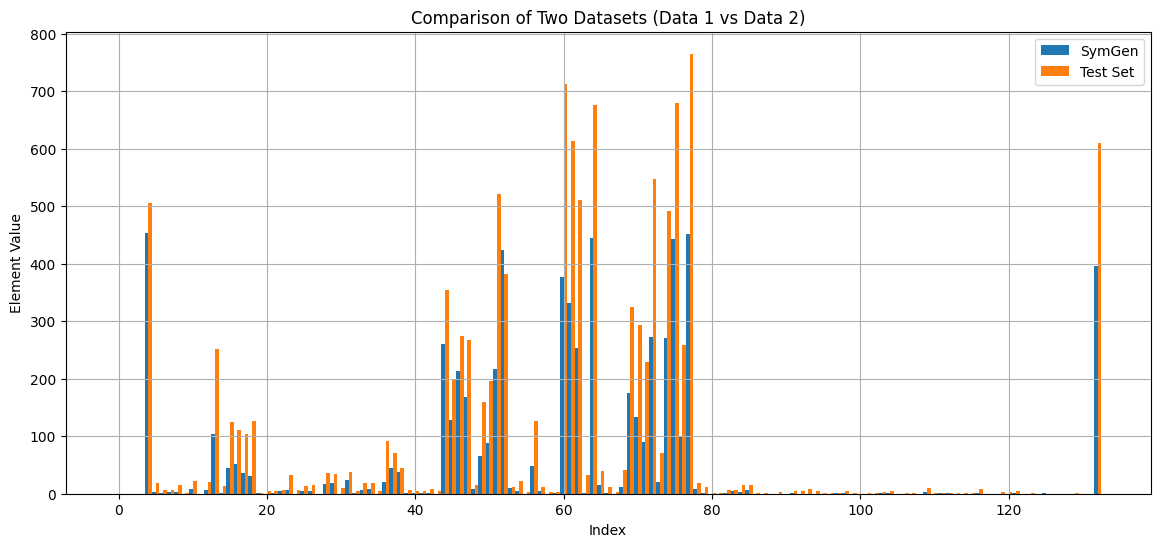

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
indices = range(len(sum_symgen_inst))
width = 0.5  # Bar width

plt.bar([i - width/2 for i in indices], sum_symgen_inst.cpu().detach().numpy(), width=width, label='SymGen')
plt.bar([i + width/2 for i in indices], sum_target_insts.cpu().detach().numpy(), width=width, label='Test Set')

plt.xlabel('Index')
plt.ylabel('Element Value')
plt.title('Comparison of Two Datasets (Data 1 vs Data 2)')
plt.legend()
plt.grid(True)
plt.show()

# model loading - Avg 1

In [ ]:
prefix = '/workspace/out/inst_pre'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vocab_size = 150
num_epochs = 500
max_len=5000
dropout=0.1
d_model = 512
num_heads = 8
d_ff = d_model*4
num_layers = 8
model = C2IEncoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, num_layers=num_layers, vocab_size=vocab_size, max_len=max_len, dropout=0.1)

model.load_state_dict(torch.load(prefix + '/Avg_1/model_63_0.9724_0.4597_0.4386.pt', map_location=device))
model.eval()
model.to(device)

In [32]:
avg1 = []
sum_avg1_jac = torch.zeros(133).long().to(device)
for (chords, targets, lengths) in tqdm(test_loader, ncols=60):
    chords = chords.to(device)
    targets = targets.to(device)
    
    outputs = model(chords)
    outputs = model.avg_inst(outputs)
    item = (outputs > 0.5).long().squeeze(0)
    sum_avg1_jac += item.squeeze(0).long()
    avg1.append(item)

  0%|                               | 0/924 [00:00<?, ?it/s]

100%|█████████████████████| 924/924 [00:49<00:00, 18.49it/s]


In [33]:
print(sum_avg1_jac)

tensor([  0,   0,   0,   0, 573,   4,   0,   3,   1,   1,   8,   0,   5, 203,
          1,  72,  77,  66,  89,   0,   1,   1,   3,  10,   0,   2,   5,   0,
         13,  16,   4,  21,   0,   6,   5,   0,  50,  50,  23,   2,   1,   0,
          0,   1, 281, 179, 287, 217,   3, 142, 142, 585, 369,   7,   8,   0,
         70,   4,   0,   0, 756, 656, 509,  11, 706,  13,   2,   1,  19, 279,
        259, 214, 590,  25, 520, 695, 218, 834,   3,   2,   0,   0,   1,   4,
          2,   4,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   1,
          0,   0,   0,   1,   0,   2,   1,   0,   0,   1,   0,   6,   0,   1,
          0,   0,   0,   0,   2,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 679], device='cuda:0')


In [34]:
# print(bos_jac)
z_z, o_o, extra, lack, err = subset_accuracy(avg1, targets_insts)
# Symgen 생성과 Target Answer 비교
print(z_z)
print(o_o)
print(extra)
print(lack)
print(err)
print(o_o / (o_o+extra+lack))

/tmp/ipykernel_1004/931628323.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds).to(device)


107509
6689
3942
4752
0
0.434830657219008


In [35]:
# Jaccard sim - 1 에 가까울수록 유사함
jarc = 0
cnt = 0
for i, t in zip(avg1, targets_insts):
    preds = torch.tensor(i).to(device)
    targets = t.squeeze(0).to(device)
    try:
        jar = jaccard_similarity(preds, targets)
        jarc += jar
        cnt += 1
    except:
        pass
print(jarc)
print(cnt)
print(jarc/cnt)

/tmp/ipykernel_1004/4177427347.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(i).to(device)


tensor(412.5208, device='cuda:0')
924
tensor(0.4465, device='cuda:0')


In [37]:
print(sum_avg1_jac)
print(sum_avg1_jac - sum_target_insts)

tensor([  0,   0,   0,   0, 573,   4,   0,   3,   1,   1,   8,   0,   5, 203,
          1,  72,  77,  66,  89,   0,   1,   1,   3,  10,   0,   2,   5,   0,
         13,  16,   4,  21,   0,   6,   5,   0,  50,  50,  23,   2,   1,   0,
          0,   1, 281, 179, 287, 217,   3, 142, 142, 585, 369,   7,   8,   0,
         70,   4,   0,   0, 756, 656, 509,  11, 706,  13,   2,   1,  19, 279,
        259, 214, 590,  25, 520, 695, 218, 834,   3,   2,   0,   0,   1,   4,
          2,   4,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   1,
          0,   0,   0,   1,   0,   2,   1,   0,   0,   1,   0,   6,   0,   1,
          0,   0,   0,   0,   2,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 679], device='cuda:0')
tensor([  0,   0,   0,   0,  67, -14,  -6,  -4, -15,   0, -14,   0, -15, -49,
        -12, -52, -34, -37, -37,  -2,  -3,  -4,  -4, -22,  -6, -11, -11,   0,
        -23, -18,  -6, -16,  -4, -13, -14,  -5, -41, -21, -21,  -4,  -3,  -4,
   

In [38]:
# JS divergence - 0일수록 동일한 분포

infer = sum_avg1_jac / sum_avg1_jac.sum()
# infer = sum_gen_inst
target = (sum_target_insts / sum_target_insts.sum()).to(device)
# target = sum_target_insts
M = 0.5 * (infer + target)
# print(infer)
# print(target)
def kl_divergence(p, q):
    epsilon = 1e-10  # 작은 상수
    return torch.sum(p * torch.log((p + epsilon) / (q + epsilon)))

js_div = 0.5*kl_divergence(infer, M) + 0.5*kl_divergence(target, M)
js_div = js_div.item()
print(js_div)

0.011948337778449059


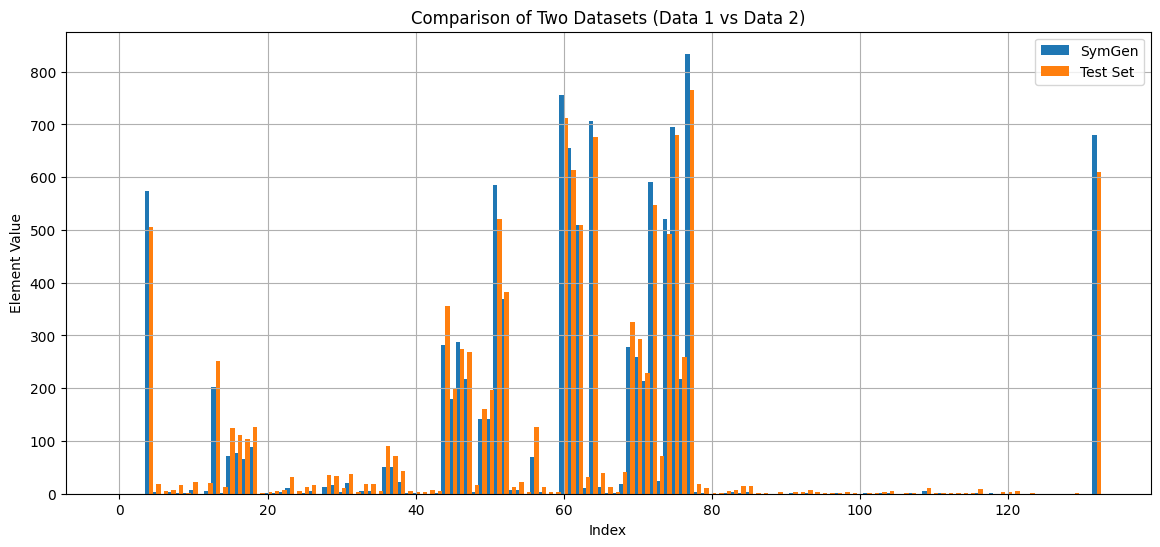

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
indices = range(len(sum_symgen_inst))
width = 0.6  # Bar width

plt.bar([i - width/2 for i in indices], sum_avg1_jac.cpu().detach().numpy(), width=width, label='SymGen')
plt.bar([i + width/2 for i in indices], sum_target_insts.cpu().detach().numpy(), width=width, label='Test Set')

plt.xlabel('Index')
plt.ylabel('Element Value')
plt.title('Comparison of Two Datasets (Data 1 vs Data 2)')
plt.legend()
plt.grid(True)
plt.show()

# Avg + Len compare

In [ ]:
prefix = '/workspace/out/inst_pre'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vocab_size = 150
num_epochs = 500
max_len=5000
dropout=0.1
d_model = 512
num_heads = 8
d_ff = d_model*4
num_layers = 8
model = C2IEncoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, num_layers=num_layers, vocab_size=vocab_size, max_len=max_len, dropout=0.1, mode='len')

model.load_state_dict(torch.load(prefix + '/Avg_LEN_1/model_8_0.4799_0.4555_0.4508.pt', map_location=device))
model.eval()
model.to(device)

In [43]:
avg_len = []
sum_avg_len = torch.zeros(133).long().to(device)
for (chords, targets, lengths) in tqdm(test_loader, ncols=60):
    chords = chords.to(device)
    targets = targets.to(device)
    
    outputs = model(chords)
    outputs = model.avg_inst(outputs, length=lengths.to(device))
    item = (outputs > 0.5).long().squeeze(0)
    sum_avg_len += item.squeeze(0).long()
    avg_len.append(item)

100%|█████████████████████| 924/924 [00:46<00:00, 19.83it/s]


In [44]:
print(sum_avg_len)

tensor([  0,   0,   0,   0, 336,   0,   0,   0,   0,   0,   0,   0,   0,  41,
          0,  15,  11,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   8,   1,   2,   2,   0,   2,   4, 453,  83,   0,   1,   0,
          0,   0,   0,   0, 852, 570, 427,   0, 734,   2,   0,   0,   0, 156,
        102,  71, 486,   3, 347, 726,  41, 872,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 698], device='cuda:0')


In [45]:
# print(bos_jac)
z_z, o_o, extra, lack, err = subset_accuracy(avg_len, targets_insts)
# Symgen 생성과 Target Answer 비교
print(z_z)
print(o_o)
print(extra)
print(lack)
print(err)
print(o_o / (o_o+extra+lack))

/tmp/ipykernel_1004/931628323.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds).to(device)


109510
5116
1941
6325
0
0.382304588252877


In [46]:
# Jaccard sim - 1 에 가까울수록 유사함


jarc = 0
cnt = 0
for i, t in zip(avg_len, targets_insts):
    preds = torch.tensor(i)
    targets = t.squeeze(0).to(device)
    try:
        jar = jaccard_similarity(preds, targets)
        jarc += jar
        cnt += 1
    except:
        pass
print(jarc)
print(cnt)
print(jarc/cnt)

/tmp/ipykernel_1004/3055259491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(i)


tensor(350.7721, device='cuda:0')
924
tensor(0.3796, device='cuda:0')


In [48]:
print(sum_avg_len)
print(sum_avg_len - sum_target_insts)

tensor([  0,   0,   0,   0, 336,   0,   0,   0,   0,   0,   0,   0,   0,  41,
          0,  15,  11,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   8,   1,   2,   2,   0,   2,   4, 453,  83,   0,   1,   0,
          0,   0,   0,   0, 852, 570, 427,   0, 734,   2,   0,   0,   0, 156,
        102,  71, 486,   3, 347, 726,  41, 872,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 698], device='cuda:0')
tensor([   0,    0,    0,    0, -170,  -18,   -6,   -7,  -16,   -1,  -22,    0,
         -20, -211,  -13, -109, -100,  -93, -126,   -2,   -4,   -5,   -7,  -32,
          -6,  -13,  -16,    0,  -36,  -34,  -10,  -37,   -4,  -19,  -19,   -

In [49]:
# JS divergence - 0일수록 동일한 분포

infer = sum_avg_len / sum_avg_len.sum()
# infer = sum_gen_inst
target = (sum_target_insts / sum_target_insts.sum()).to(device)
# target = sum_target_insts
M = 0.5 * (infer + target)
# print(infer)
# print(target)
def kl_divergence(p, q):
    epsilon = 1e-10  # 작은 상수
    return torch.sum(p * torch.log((p + epsilon) / (q + epsilon)))

js_div = 0.5*kl_divergence(infer, M) + 0.5*kl_divergence(target, M)
js_div = js_div.item()
print(js_div)

0.11265507340431213


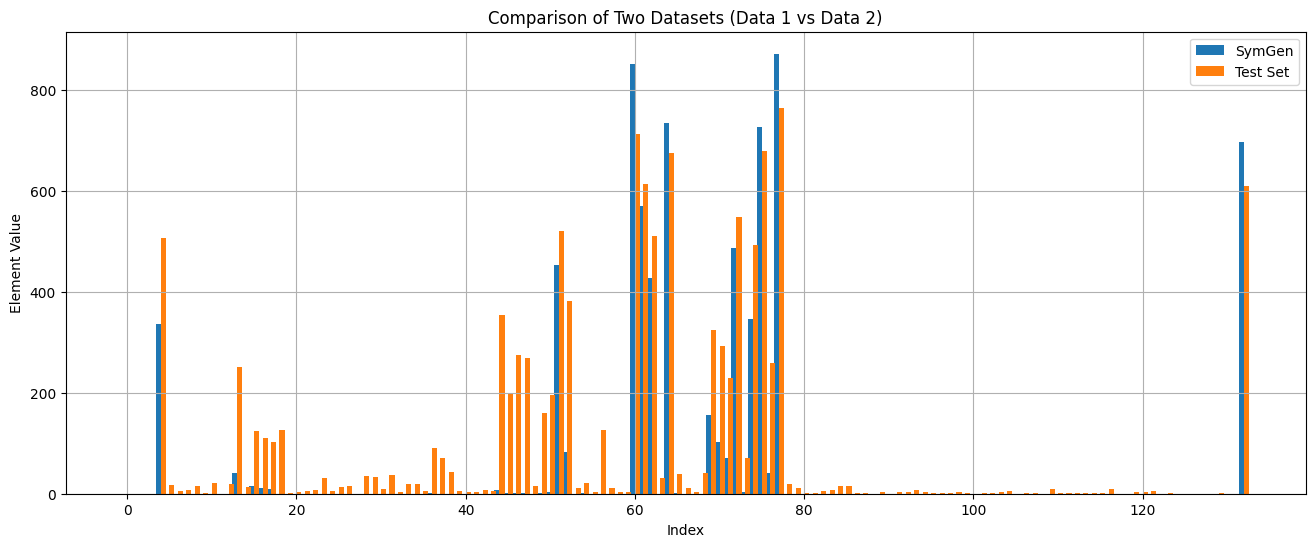

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
indices = range(len(sum_symgen_inst))
width = 0.6  # Bar width

plt.bar([i - width/2 for i in indices], sum_avg_len.cpu().detach().numpy(), width=width, label='SymGen')
plt.bar([i + width/2 for i in indices], sum_target_insts.cpu().detach().numpy(), width=width, label='Test Set')

plt.xlabel('Index')
plt.ylabel('Element Value')
plt.title('Comparison of Two Datasets (Data 1 vs Data 2)')
plt.legend()
plt.grid(True)
plt.show()

# Proj_1 + LEN Compare

In [ ]:
prefix = '/workspace/out/inst_pre'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vocab_size = 150
num_epochs = 500
max_len=5000
dropout=0.1
d_model = 512
num_heads = 8
d_ff = d_model*4
num_layers = 8
model = C2IEncoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, num_layers=num_layers, vocab_size=vocab_size, max_len=max_len, dropout=0.1)

model.load_state_dict(torch.load(prefix + '/Proj_LEN_1/model_76_0.9807_0.4524_0.4397.pt', map_location=device))
model.eval()
model.to(device)

In [145]:
avg_len = []
sum_avg_len = torch.zeros(133).long().to(device)
for (chords, targets, lengths) in tqdm(test_loader, ncols=60):
    chords = chords.to(device)
    targets = targets.to(device)
    
    outputs = model(chords)
    outputs = model.proj_inst(outputs, length=lengths.to(device))
    item = (outputs > 0.5).long().squeeze(0)
    sum_avg_len += item.squeeze(0).long()
    avg_len.append(item)

100%|█████████████████████| 924/924 [00:45<00:00, 20.40it/s]


In [146]:
print(sum_avg_len)

tensor([  0,   0,   0,   0, 508,   4,   2,   2,   2,   0,   7,   0,  10, 168,
          1,  79,  50,  58,  75,   0,   1,   1,   1,   5,   1,   3,   4,   0,
         11,   8,   8,  11,   2,   4,   6,   1,  72,  41,  19,   1,   0,   1,
          0,   0, 323, 158, 240, 235,   7, 136, 118, 553, 359,   4,   8,   1,
         73,   4,   0,   0, 755, 627, 526,  12, 698,  22,   3,   0,  22, 267,
        224, 164, 613,  28, 492, 691, 195, 817,   4,   0,   0,   0,   1,   3,
          1,   3,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   2,
          0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   3,   0,   0,
          0,   1,   0,   0,   2,   0,   2,   0,   2,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0, 646], device='cuda:0')


In [147]:
# print(bos_jac)
z_z, o_o, extra, lack, err = subset_accuracy(avg_len, targets_insts)
# Symgen 생성과 Target Answer 비교
print(z_z)
print(o_o)
print(extra)
print(lack)
print(err)
print(o_o / (o_o+extra+lack))

107803
6569
3648
4872
0
0.43535025515276027


In [148]:
# Jaccard sim - 1 에 가까울수록 유사함


jarc = 0
cnt = 0
for i, t in zip(avg_len, targets_insts):
    preds = torch.tensor(i)
    targets = t.squeeze(0).to(device)
    try:
        jar = jaccard_similarity(preds, targets)
        jarc += jar
        cnt += 1
    except:
        pass
print(jarc)
print(cnt)
print(jarc/cnt)

/tmp/ipykernel_5645/3055259491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(i)


tensor(416.0846, device='cuda:0')
924
tensor(0.4503, device='cuda:0')


In [149]:
print(sum_avg_len)
sum_target_insts = sum_target_insts.to(device)
print(sum_target_insts)
print(sum_avg_len - sum_target_insts)

tensor([  0,   0,   0,   0, 508,   4,   2,   2,   2,   0,   7,   0,  10, 168,
          1,  79,  50,  58,  75,   0,   1,   1,   1,   5,   1,   3,   4,   0,
         11,   8,   8,  11,   2,   4,   6,   1,  72,  41,  19,   1,   0,   1,
          0,   0, 323, 158, 240, 235,   7, 136, 118, 553, 359,   4,   8,   1,
         73,   4,   0,   0, 755, 627, 526,  12, 698,  22,   3,   0,  22, 267,
        224, 164, 613,  28, 492, 691, 195, 817,   4,   0,   0,   0,   1,   3,
          1,   3,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,   2,
          0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   3,   0,   0,
          0,   1,   0,   0,   2,   0,   2,   0,   2,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0, 646], device='cuda:0')
tensor([  0,   0,   0,   0, 506,  18,   6,   7,  16,   1,  22,   0,  20, 252,
         13, 124, 111, 103, 126,   2,   4,   5,   7,  32,   6,  13,  16,   0,
         36,  34,  10,  37,   4,  19,  19,   5,  91,  71,  44,   6,   4,   4,
   

In [150]:
# JS divergence - 0일수록 동일한 분포

infer = sum_avg_len / sum_avg_len.sum()
# infer = sum_gen_inst
target = (sum_target_insts / sum_target_insts.sum()).to(device)
# target = sum_target_insts
M = 0.5 * (infer + target)
# print(infer)
# print(target)
def kl_divergence(p, q):
    epsilon = 1e-10  # 작은 상수
    return torch.sum(p * torch.log((p + epsilon) / (q + epsilon)))

js_div = 0.5*kl_divergence(infer, M) + 0.5*kl_divergence(target, M)
js_div = js_div.item()
print(js_div)

0.012852976098656654


# Proj_1

In [ ]:
prefix = '/workspace/out/inst_pre'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vocab_size = 150
num_epochs = 500
max_len=5000
dropout=0.1
d_model = 512
num_heads = 8
d_ff = d_model*4
num_layers = 8
model = C2IEncoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, num_layers=num_layers, vocab_size=vocab_size, max_len=max_len, dropout=0.1)

model.load_state_dict(torch.load(prefix + '/Proj_1/model_66_0.9659_0.4616_0.4460.pt', map_location=device))
model.eval()
model.to(device)

In [155]:
avg_len = []
sum_avg_len = torch.zeros(133).long().to(device)
for (chords, targets, lengths) in tqdm(test_loader, ncols=60):
    chords = chords.to(device)
    targets = targets.to(device)
    
    outputs = model(chords)
    outputs = model.proj_inst(outputs)
    item = (outputs > 0.5).long().squeeze(0)
    sum_avg_len += item.squeeze(0).long()
    avg_len.append(item)

100%|█████████████████████| 924/924 [00:44<00:00, 20.69it/s]


In [156]:
print(sum_avg_len)

tensor([  0,   0,   0,   0, 540,   4,   1,   1,   1,   0,   3,   0,   8, 147,
          5,  53,  53,  54,  58,   0,   1,   1,   3,  13,   2,   2,   3,   0,
          8,  13,   1,  11,   0,   4,   8,   1,  27,  44,  22,   2,   1,   0,
          0,   1, 293, 149, 228, 192,  11, 114, 141, 562, 403,   4,   8,   1,
         69,   3,   0,   0, 769, 628, 510,   8, 732,  15,   2,   2,  15, 265,
        176, 138, 612,  28, 459, 731, 221, 809,   8,   1,   0,   0,   1,   1,
          0,   4,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   2,   0,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 653], device='cuda:0')


In [157]:
# print(bos_jac)
z_z, o_o, extra, lack, err = subset_accuracy(avg_len, targets_insts)
# Symgen 생성과 Target Answer 비교
print(z_z)
print(o_o)
print(extra)
print(lack)
print(err)
print(o_o / (o_o+extra+lack))

107964
6583
3487
4858
0
0.4409833869239014


In [158]:
# Jaccard sim - 1 에 가까울수록 유사함


jarc = 0
cnt = 0
for i, t in zip(avg_len, targets_insts):
    preds = torch.tensor(i)
    targets = t.squeeze(0).to(device)
    try:
        jar = jaccard_similarity(preds, targets)
        jarc += jar
        cnt += 1
    except:
        pass
print(jarc)
print(cnt)
print(jarc/cnt)

tensor(419.7626, device='cuda:0')
924
tensor(0.4543, device='cuda:0')


/tmp/ipykernel_5645/3055259491.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(i)


In [159]:
print(sum_avg_len)
sum_target_insts = sum_target_insts.to(device)
print(sum_target_insts)
print(sum_avg_len - sum_target_insts)

tensor([  0,   0,   0,   0, 540,   4,   1,   1,   1,   0,   3,   0,   8, 147,
          5,  53,  53,  54,  58,   0,   1,   1,   3,  13,   2,   2,   3,   0,
          8,  13,   1,  11,   0,   4,   8,   1,  27,  44,  22,   2,   1,   0,
          0,   1, 293, 149, 228, 192,  11, 114, 141, 562, 403,   4,   8,   1,
         69,   3,   0,   0, 769, 628, 510,   8, 732,  15,   2,   2,  15, 265,
        176, 138, 612,  28, 459, 731, 221, 809,   8,   1,   0,   0,   1,   1,
          0,   4,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   2,   0,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 653], device='cuda:0')
tensor([  0,   0,   0,   0, 506,  18,   6,   7,  16,   1,  22,   0,  20, 252,
         13, 124, 111, 103, 126,   2,   4,   5,   7,  32,   6,  13,  16,   0,
         36,  34,  10,  37,   4,  19,  19,   5,  91,  71,  44,   6,   4,   4,
   

In [160]:
# JS divergence - 0일수록 동일한 분포

infer = sum_avg_len / sum_avg_len.sum()
# infer = sum_gen_inst
target = (sum_target_insts / sum_target_insts.sum()).to(device)
# target = sum_target_insts
M = 0.5 * (infer + target)
# print(infer)
# print(target)
def kl_divergence(p, q):
    epsilon = 1e-10  # 작은 상수
    return torch.sum(p * torch.log((p + epsilon) / (q + epsilon)))

js_div = 0.5*kl_divergence(infer, M) + 0.5*kl_divergence(target, M)
js_div = js_div.item()
print(js_div)

0.015964534133672714
